# Machine Learning - Classification

### Goal: 
+ Predict whether a biopsied breast cell is benign (not harmful) or malignant (cancerous)

### Summary of Results:
+ This is a classification problem.
+ I dealt with imbalanced classes by implementing SMOTE to up-sample the benign class.
+ I used logistic regression as the baseline and found an accuracy score of 97.3%.
+ I then compared logistic regression with alternative classification models including random forest, support vector machines and naive bayes.  
+ Logistic regression, random forest classifier and naive bayes result in similar accuracy scores of 97.3%. The voting classifier slightly outperforms all the individual classifiers with an accuracy score of 97.8%. 

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from numpy.core.umath_tests import inner1d
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from imblearn.over_sampling import SMOTE

/Users/anhdo/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  after removing the cwd from sys.path.


In [2]:
#Load the dataset
data = pd.read_csv('../breast-cancer-wisconsin.csv', header = None)

# Data Exploratory Analysis

In [3]:
data.head()

0   1   2   3   4   5   6   7   8   9   10
0  1000025   5   1   1   1   2   1   3   1   1   2
1  1002945   5   4   4   5   7  10   3   2   1   2
2  1015425   3   1   1   1   2   2   3   1   1   2
3  1016277   6   8   8   1   3   4   3   7   1   2
4  1017023   4   1   1   3   2   1   3   1   1   2

In [4]:
# Name columns and drop column 'id'
data.columns = ['id', 'clump_thickness', 'cell_size', 'cell_shape', 'adhesion', 'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'class']


In [5]:
# Check out a detailed report of the dataset
data.profile_report()

# Observations:

Nuclei is the only categorical feature, all others are numeric. 1 category of nuclei is '?'.

Classification: benign (457 cases = 65.5%), malignant (241 cases = 34.5%)

Cell_shape and cell_size are highly correlated: corr = 0.9

# Create the target variable

In [6]:
#Created a new variable 'y' where 1 means malignant, 0 means benign
data['y'] = np.where(data['class'] == 4, 1, 0)
#Remove column 'class'
del data['class']

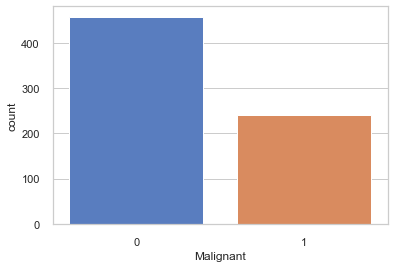

In [7]:
sns.countplot(x = 'y', data = data, palette="muted")
plt.xlabel('Malignant')
plt.show()

2 classes are imbalanced, and the ratio of malignant to benign instances is 34.5% vs. 65.5%. Before we go ahead to balance the classes, Let's do some more exploration.

In [8]:
#Convert 'nuclei' to numeric, '?' will become missing values.
data['nuclei'] = pd.to_numeric(data['nuclei'], errors='coerce')

In [9]:
data.isnull().sum()

id                  0
clump_thickness     0
cell_size           0
cell_shape          0
adhesion            0
epithelial          0
nuclei             16
chromatin           0
nucleoli            0
mitoses             0
y                   0
dtype: int64

In [10]:
#Drop 16 missing cells caused by '?'
data = data.dropna()

In [11]:
#Drop column 'id'
del data['id']

In [12]:
data.columns.values

array(['clump_thickness', 'cell_size', 'cell_shape', 'adhesion',
       'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'y'],
      dtype=object)

In [13]:
data.groupby('y').mean()

clump_thickness  cell_size  cell_shape  adhesion  epithelial    nuclei  \
y                                                                           
0         2.963964   1.306306    1.414414  1.346847    2.108108  1.346847   
1         7.188285   6.577406    6.560669  5.585774    5.326360  7.627615   

   chromatin  nucleoli   mitoses  
y                                 
0   2.083333  1.261261  1.065315  
1   5.974895  5.857741  2.602510

Higher number across all features are associated with a cell being malignant.


# Over-sampling using SMOTE

In [14]:
X = data.drop(['y'], axis=1)
y = data[['y']]

In [15]:
os = SMOTE(random_state =0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of benign oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of malignant",len(os_data_y[os_data_y['y']==1]))
print("Proportion of benign data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of malignant data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

Length of oversampled data is  628
Number of benign oversampled data 314
Number of malignant 314
Proportion of benign data in oversampled data is  0.5
Proportion of malignant data in oversampled data is  0.5


/Users/anhdo/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
os_data_X.head()

clump_thickness  cell_size  cell_shape  adhesion  epithelial  nuclei  \
0              8.0        6.0         4.0       3.0         5.0     9.0   
1              4.0        1.0         1.0       1.0         1.0     1.0   
2              8.0       10.0         8.0       8.0         4.0     8.0   
3              5.0        2.0         2.0       2.0         2.0     1.0   
4              8.0        4.0         4.0       5.0         4.0     7.0   

   chromatin  nucleoli  mitoses  
0        3.0       1.0      1.0  
1        2.0       1.0      1.0  
2        7.0       7.0      1.0  
3        2.0       2.0      1.0  
4        7.0       8.0      2.0

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/anhdo/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


# Model Selection

First, I'll try a logistic regression because it is relatively simple and fast.

## Logistic Regression

In [19]:
X=os_data_X
y=os_data_y['y']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [21]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.97


### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[90  3]
 [ 2 94]]


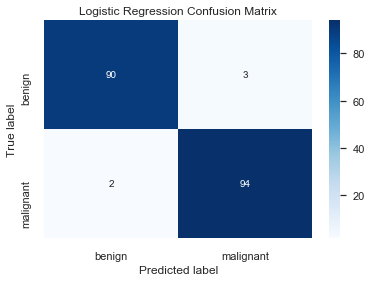

In [24]:
import seaborn as sn
ax = sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues, xticklabels=['benign','malignant'], yticklabels=['benign','malignant'])
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

### ROC Curve

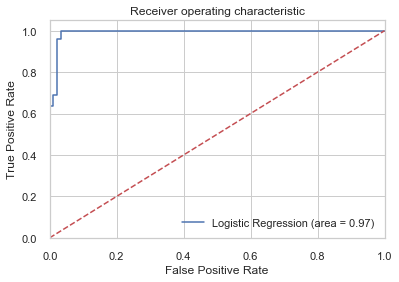

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

This looks pretty good. Because this is a classification problem, there are several alternative models: random forest classifier, K neighbors classifier, SVC and Gaussian Naive Bayes. Let's try an emseble method.

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma = 'auto', kernel = 'rbf', probability = True)
k_clf = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
nb_clf = GaussianNB()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('k', k_clf), ('nb', nb_clf)],
    voting='soft')

In [27]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('nb', GaussianNB(priors=None))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [28]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, k_clf, nb_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9735449735449735
RandomForestClassifier 0.9735449735449735
SVC 0.9629629629629629
KNeighborsClassifier 0.9682539682539683
GaussianNB 0.9735449735449735
VotingClassifier 0.9788359788359788


/Users/anhdo/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Logistic regression, random forest classifier and Gaussian NB result in similar accuracy scores of 97.3%. The voting classifier slightly outperforms all the individual classifiers. Accuracy = 97.8%

# 5 Fold Cross-Validation

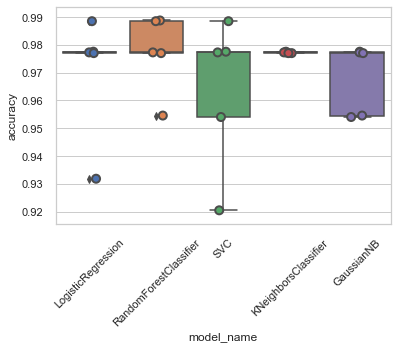

In [29]:
from sklearn.model_selection import cross_val_score
models = [
    LogisticRegression(solver="liblinear", random_state=42),
    RandomForestClassifier(n_estimators=10, random_state=42),
    SVC(gamma = 'auto', kernel = 'rbf'),
    KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
    GaussianNB(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=45)
plt.show()